### Synthetic data generation: overview and config
- Goal: create clustered synthetic vectors, visualize with UMAP, and produce ground-truth nearest neighbors for benchmarking.
- Configure dataset size, dimensionality, precision, and sharding.
- Important knobs:
  - `total_vectors`, `vectors_per_centroid`, derived `total_centroids`
  - `dim`, `precision` (`fp32`/`fp16`/`int*`) and quantization settings
  - `queries_per_blob` for per-blob query sampling
  - `top_c_centroids` (candidate filter) and `gt_k` (final k)
  - `save_dir` for all outputs


In [1]:
# total vectors that you want to generate
total_vectors = 20000000

# total vectors per centroid
vectors_per_centroid = 100000

# total number of centroids
total_centroids = total_vectors // vectors_per_centroid
print(f"total_centroids: {total_centroids}")

# dimension of the vectors
dim = 1024

# output precision: 'fp32' | 'fp16' | 'int'
precision = 'fp32'

# integer dtype if precision == 'int': 'int8' | 'uint8' | 'int16' | 'int32'
int_dtype = 'int8'

# scale factor for int quantization (normal * scale -> clip -> cast)
int_scale = 16.0

# batched centroid generation to avoid OOM; shards saved if needed
centroid_batch_size = 1_000_000

# per make_blobs batch, number of query points to sample and save
queries_per_blob = 1000

# ground-truth params
top_c_centroids = 4
gt_k = 10

# directory for sharded centroids when num_centroids > centroid_batch_size
save_dir = "/raid/data/synth"

#total vectors for training centroids
max_centroids_pool_size = 1_000_000


total_centroids: 200


### Generate centroids with cuVS K-Means (then casting)
- Learn `total_centroids × dim` centroids using cuVS K-Means on a pool of size `min(3_000_000, total_vectors)` sampled from N(0,1)`; keep these fixed for all downstream generation.
- This yields space-filling centroids (vs i.i.d. normals) and prints K-Means timing for visibility.
- `cast(x)` enforces the output `precision`:
  - `fp32` / `fp16` float
  - `int*` quantized with `int_scale`, clipped to target integer dtype.
- Centroids are saved under `save_dir/centroids/` as a single file or shard series.


In [2]:
import os, time, cupy as cp
from cuvs.cluster import kmeans as cuvs_kmeans
cp.random.seed(42)

nc, D = int(total_centroids), int(dim)
fp = {'fp32': cp.float32, 'fp16': cp.float16}.get(precision)
int_dt = {'int8': cp.int8, 'uint8': cp.uint8, 'int16': cp.int16, 'int32': cp.int32}.get(int_dtype, cp.int8)

os.makedirs(f"{save_dir}/centroids", exist_ok=True)

def cast(x):
    if precision == 'int':
        info = cp.iinfo(int_dt)
        return cp.clip(cp.rint(x * float(int_scale)), info.min, info.max).astype(int_dt)
    return x.astype(fp or cp.float32)

pool_n = min(max_centroids_pool_size, int(total_vectors))
X_pool = cp.random.normal(0, 1, (pool_n, D), dtype=cp.float32)

# Fit cuVS KMeans (params first)
t0 = time.perf_counter()
params = cuvs_kmeans.KMeansParams(n_clusters=nc)
km_res = cuvs_kmeans.fit(params, X_pool)
C = getattr(km_res, 'centroids', km_res[0])
t1 = time.perf_counter()

C = cp.asarray(C, dtype=cp.float32)
cp.save(f"{save_dir}/centroids/centroids.npy", cast(C))
print(f"[cuVS KMeans] pool={pool_n:,} k={nc} dim={D} time={t1 - t0:.2f}s -> {save_dir}/centroids/centroids.npy")

[cuVS KMeans] pool=1,000,000 k=200 dim=1024 time=3.74s -> /raid/data/synth/centroids/centroids.npy


### Generate blobs + queries (GPU-first)
- For each centroid shard, synthesize `vectors_per_centroid` samples per centroid with `cuml.datasets.make_blobs` and per-centroid stddev.
- Compute `global_labels` as centroid ids offset by shard start.
- Split each batch into:
  - Base vectors: saved as `blobs_s*_n*.npy` and `*.labels.npy`.
  - Query vectors: saved as `*.queries.npy` and `*.queries.labels.npy` (disjoint from base).
- Apply `cast` to enforce `precision` (`fp32`, `fp16`, or quantized `int*`).


In [4]:
# Generate blobs around centroids with random stddev (batched, GPU-first)
import os, cupy as cp
cp.random.seed(42)
from cuml.datasets import make_blobs as mk; gpu=True


D=int(dim); k_per=int(vectors_per_centroid); sb=1_000_000
out_dir=f"{save_dir}/blobs"; os.makedirs(out_dir, exist_ok=True)

def centers_iter():
    if 'centroids' in globals():
        yield centroids, 0
    elif os.path.exists(f"{save_dir}/centroids/centroids.npy"):
        yield cp.load(f"{save_dir}/centroids/centroids.npy"), 0
    else:
        cdir=f"{save_dir}/centroids"
        for p in sorted([p for p in os.listdir(cdir) if p.endswith('.npy')]):
            s=int(p.split('_s')[1].split('_')[0]); yield cp.load(f"{cdir}/{p}"), s

def cast(x):
    try:
        return globals()['cast'](x)
    except Exception:
        if precision=='int':
            dt={'int8':cp.int8,'uint8':cp.uint8,'int16':cp.int16,'int32':cp.int32}[int_dtype]
            info=cp.iinfo(dt); return cp.clip(cp.rint(x*float(int_scale)), info.min, info.max).astype(dt)
        return x.astype(cp.float16 if precision=='fp16' else cp.float32)

for C, base in centers_iter():
    m=max(1, sb//k_per)
    for s in range(0, len(C), m):
        Cb=C[s:s+m]; stds=cp.random.uniform(0.05,0.5, len(Cb))
        n=k_per*len(Cb)
        if gpu:
            X,y=mk(n_samples=n, n_features=D, centers=Cb, cluster_std=stds, random_state=42)
            X=cp.asarray(X); y=cp.asarray(y, dtype=cp.int32)
        else:
            import numpy as np
            X,y=mk(n_samples=n, n_features=D, centers=cp.asnumpy(Cb), cluster_std=cp.asnumpy(stds), random_state=42)
            X=cp.asarray(X); y=cp.asarray(y, dtype=cp.int32)
        global_labels = y + (base + s)
        shard = f"{out_dir}/blobs_s{base+s:012d}_n{n:012d}"
        # Split into base and queries (disjoint)
        q = int(min(max(1, int(queries_per_blob)), n))
        q_idx = cp.random.permutation(n)[:q]
        mask = cp.ones(n, dtype=cp.bool_); mask[q_idx] = False
        base_idx = cp.nonzero(mask)[0]
        # Save base shard (queries removed)
        cp.save(f"{shard}.npy", cast(X[base_idx]))
        cp.save(f"{shard}.labels.npy", global_labels[base_idx])
        # Save queries
        cp.save(f"{shard}.queries.npy", cast(X[q_idx]))
        cp.save(f"{shard}.queries.labels.npy", global_labels[q_idx])


# Visualize the synthetic data with UMAP-

### UMAP preview (sampled subset on GPU)
- Randomly sample up to `sample_size` vectors across blob shards (capped per-shard) using CPU memmaps.
- Move samples to GPU (`cupy`) and run `cuml.manifold.UMAP` to 2D.
- Visualize with matplotlib, colored by sampled blob shard id; if plotting unavailable, save:
  - `umap_2d.npy` and `umap_labels.npy` under `save_dir`.


[2025-12-03 11:08:21.461] [CUML] [info] build_algo set to brute_force_knn because random_state is given


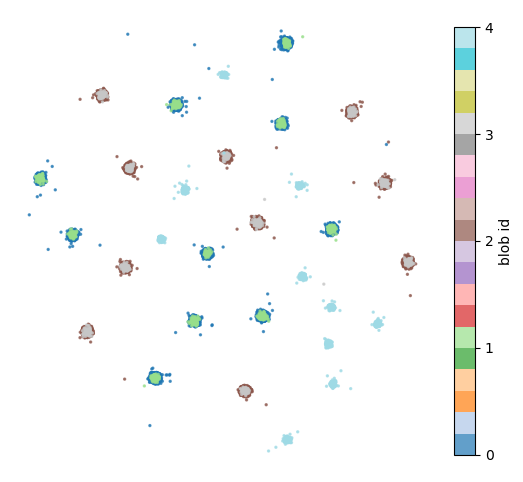

In [5]:
# UMAP visualization on a subset (GPU-first), colored by blob shard
import os, glob, numpy as np, cupy as cp
from cuml.manifold import UMAP

sample_size = 50000  # adjust to fit GPU memory
paths = sorted(p for p in glob.glob(f"{save_dir}/blobs/*.npy") if not p.endswith('.labels.npy'))
assert paths, f"No blob shards found in {save_dir}/blobs"

need = sample_size
batches, labels = [], []
rng = np.random.default_rng(42)
for b, p in enumerate(paths):
    if need <= 0:
        break
    a = np.load(p, mmap_mode='r')  # CPU memmap (no full load)
    n = a.shape[0]
    m = min(need, min(20000, n))   # cap per-shard sample to avoid RAM/GPU spikes
    idx = rng.choice(n, size=m, replace=False)
    batches.append(cp.asarray(a[idx], dtype=cp.float32))
    labels.append(cp.full((m,), b, dtype=cp.int32))
    need -= m

X = cp.concatenate(batches, axis=0)
L = cp.concatenate(labels, axis=0)
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
Y = umap.fit_transform(X)

try:
    import matplotlib.pyplot as plt
    Yh = cp.asnumpy(Y); Lh = cp.asnumpy(L)
    plt.figure(figsize=(6,6))
    sc = plt.scatter(Yh[:,0], Yh[:,1], c=Lh, s=2, alpha=0.7, cmap='tab20')
    cb = plt.colorbar(sc, fraction=0.046, pad=0.04)
    cb.set_label('blob id')
    uniq = np.unique(Lh)
    if uniq.size <= 20:
        cb.set_ticks(uniq)
    else:
        sel = np.linspace(0, uniq.size - 1, num=20, dtype=int)
        cb.set_ticks(uniq[sel])
    plt.axis('off'); plt.show()
except Exception:
    cp.save(f"{save_dir}/umap_2d.npy", Y)
    cp.save(f"{save_dir}/umap_labels.npy", L)


### Ground-truth neighbors (cuVS brute force over centroid-filtered candidates)
- Build a single GPU index over all centroids.
- For each query shard:
  - Find top `top_c_centroids` nearest centroids per query.
  - For each base shard, mask rows whose labels match any selected centroid.
  - Stream masked rows in chunks to fit GPU memory; run brute-force kNN on each chunk.
  - Merge chunk results per query using partial selection to keep global top-`gt_k`.
- Outputs per query shard:
  - `*.gt_neighbors.distances.npy`: squared Euclidean distances, shape `(num_queries, gt_k)`.
  - `*.gt_neighbors.labels.npy`: generating centroid ids for the returned neighbors.
  - `*.gt_neighbors.point_ids.npy`: 64-bit global ids `(shard_id << 32) | row_idx` for neighbor rows.


In [6]:
# cuVS brute-force over centroids, then chunked candidate search
import glob, os, cupy as cp, numpy as np
from cuvs.neighbors import brute_force as bf

# Load centroids and build index
centroid_paths = [f"{save_dir}/centroids/centroids.npy"] if os.path.exists(f"{save_dir}/centroids/centroids.npy") else \
                 sorted(glob.glob(f"{save_dir}/centroids/centroids_*.npy"))
assert centroid_paths, "No centroids found"
C = cp.concatenate([cp.load(p) for p in centroid_paths]).astype(cp.float32)
centroid_index = bf.build(C, metric="sqeuclidean")

# Base shards (data and labels)
base = [(p, p[:-4] + '.labels.npy') for p in sorted(glob.glob(f"{save_dir}/blobs/blobs_s*_n*.npy"))
        if (not p.endswith('.labels.npy') and not p.endswith('.queries.npy') and '.gt_neighbors.' not in p)]

# Config
cand_chunk_rows = 1_000_000  # tune per GPU mem
use_fp16 = False
dtype = cp.float16 if use_fp16 else cp.float32

# Iterate query shards
for qpath in sorted(glob.glob(f"{save_dir}/blobs/*.queries.npy")):
    pref = qpath.replace('.queries.npy', '')
    Q = cp.load(qpath).astype(dtype)
    _ = cp.load(f"{pref}.queries.labels.npy")  # for completeness

    # Candidate centroids (union over all queries)
    _, n_cent = bf.search(centroid_index, Q, top_c_centroids)
    cand_cpu = cp.asnumpy(cp.unique(cp.asarray(n_cent)).astype(cp.int32))

    # Running top-k across chunks
    qn, k = Q.shape[0], int(gt_k)
    best_d = cp.full((qn, k), cp.inf, dtype=cp.float32 if not use_fp16 else cp.float16)
    best_l = cp.full((qn, k), -1, dtype=cp.int64)
    best_r = cp.full((qn, k), -1, dtype=cp.int64)
    best_s = cp.full((qn, k), -1, dtype=cp.int32)

    # Stream candidates shard-by-shard
    for shard_id, (bpath, lpath) in enumerate(base):
        Lm = np.load(lpath, mmap_mode='r')
        idx_cpu = np.flatnonzero(np.isin(Lm, cand_cpu))
        if idx_cpu.size == 0:
            continue
        Xm = np.load(bpath, mmap_mode='r')

        for start in range(0, idx_cpu.size, cand_chunk_rows):
            sl = idx_cpu[start:start + cand_chunk_rows]
            Xc = cp.asarray(Xm[sl], dtype=dtype)
            Lc = cp.asarray(Lm[sl])

            chunk_index = bf.build(Xc, metric="sqeuclidean")
            d_nn, n_nn = bf.search(chunk_index, Q, k)
            d_nn = cp.asarray(d_nn); n_nn = cp.asarray(n_nn)
            l_nn = Lc[n_nn]
            r_nn = cp.asarray(sl)[n_nn]
            s_nn = cp.full(r_nn.shape, shard_id, dtype=cp.int32)

            # Merge with running best
            all_d = cp.concatenate([best_d, d_nn], 1)
            all_l = cp.concatenate([best_l, l_nn], 1)
            all_r = cp.concatenate([best_r, r_nn], 1)
            all_s = cp.concatenate([best_s, s_nn], 1)
            sel = cp.argpartition(all_d, k - 1, axis=1)[:, :k]
            best_d = cp.take_along_axis(all_d, sel, 1)
            best_l = cp.take_along_axis(all_l, sel, 1)
            best_r = cp.take_along_axis(all_r, sel, 1)
            best_s = cp.take_along_axis(all_s, sel, 1)

    cp.save(f"{pref}.gt_neighbors.distances.npy", best_d)
    cp.save(f"{pref}.gt_neighbors.labels.npy", best_l)
    cp.save(f"{pref}.gt_neighbors.point_ids.npy", (best_s.astype(cp.int64) << 32) | best_r.astype(cp.int64))


### Visual validation of ground-truth
- Shard vs shard heatmap of neighbor counts (should be diagonal-dominant if data is per-shard per-centroid).
- Saved vs recomputed distance scatter and |delta| histogram for a small random sample.


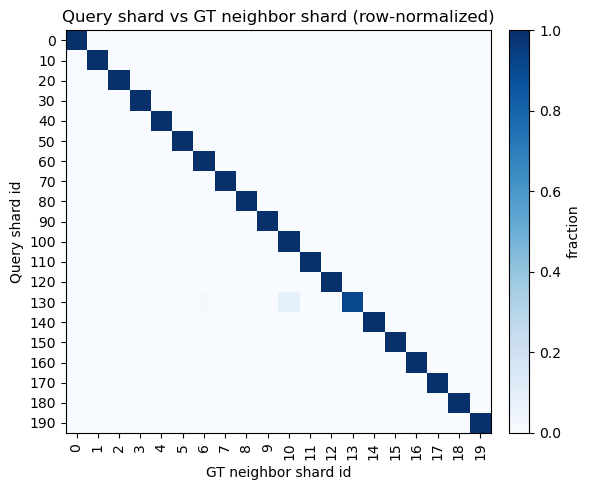

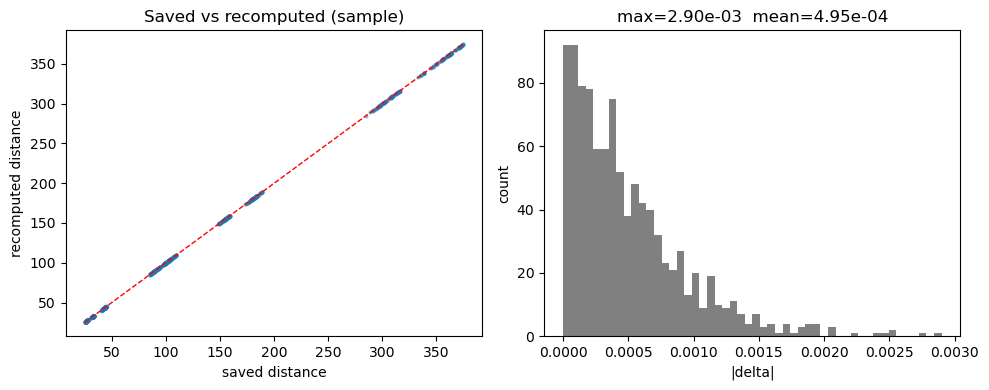

In [8]:
# Heatmap: query shard vs GT neighbor shard; and distance scatter validation
import os, glob, numpy as np, cupy as cp
import matplotlib.pyplot as plt

# Build confusion (counts) of query shard -> neighbor shard
qpaths = sorted(glob.glob(f"{save_dir}/blobs/*.queries.npy"))
assert qpaths, f"No query shards in {save_dir}/blobs"

# Row ids: query shard ids
row_ids = sorted(int(os.path.basename(p).replace('.queries.npy','').split('_s')[1].split('_')[0]) for p in qpaths)
row_idx_of = {sid:i for i, sid in enumerate(row_ids)}

# First pass: collect all neighbor shard ids across all queries
col_id_set = set()
for qpath in qpaths:
    pref = qpath.replace('.queries.npy', '')
    pid_path = f"{pref}.gt_neighbors.point_ids.npy"
    if not os.path.exists(pid_path):
        continue
    ids = cp.load(pid_path)
    sh_h = cp.asnumpy((ids >> 32).astype(cp.int32))
    col_id_set.update(int(sid) for sid in np.unique(sh_h[sh_h >= 0]))
col_ids = sorted(col_id_set)
col_idx_of = {sid:i for i, sid in enumerate(col_ids)}

# Allocate and fill
M = np.zeros((len(row_ids), len(col_ids)), dtype=np.int64)
for qpath in qpaths:
    pref = qpath.replace('.queries.npy', '')
    pid_path = f"{pref}.gt_neighbors.point_ids.npy"
    if not os.path.exists(pid_path):
        continue
    q_sid = int(os.path.basename(pref).split('_s')[1].split('_')[0])
    if q_sid not in row_idx_of:
        continue
    row = row_idx_of[q_sid]
    ids = cp.load(pid_path)
    sh_h = cp.asnumpy((ids >> 32).astype(cp.int32))
    valid = sh_h >= 0
    cols, counts = np.unique(sh_h[valid], return_counts=True)
    for c, n in zip(cols, counts):
        M[row, col_idx_of[int(c)]] += int(n)

# Normalize rows to rates for visualization
R = M / np.maximum(M.sum(axis=1, keepdims=True), 1)
plt.figure(figsize=(6,5))
im = plt.imshow(R, cmap='Blues', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
plt.title('Query shard vs GT neighbor shard (row-normalized)')
plt.xlabel('GT neighbor shard id')
plt.ylabel('Query shard id')
plt.xticks(range(len(col_ids)), col_ids, rotation=90)
plt.yticks(range(len(row_ids)), row_ids)
plt.colorbar(im, fraction=0.046, pad=0.04, label='fraction')
plt.tight_layout(); plt.show()

# Saved vs recomputed distance check (sample small)
try:
    # Pick first query shard
    qpath = qpaths[0]
    pref = qpath.replace('.queries.npy', '')
    Q = cp.load(qpath).astype(cp.float32)
    d_saved = cp.load(f"{pref}.gt_neighbors.distances.npy")
    ids = cp.load(f"{pref}.gt_neighbors.point_ids.npy")

    # base shards (for loading vectors by shard)
    base_paths = sorted(
        p for p in glob.glob(f"{save_dir}/blobs/blobs_s*_n*.npy")
        if (not p.endswith('.labels.npy') and not p.endswith('.queries.npy') and '.gt_neighbors.' not in p)
    )

    # sample queries
    rng = np.random.default_rng(123)
    qn, k = int(Q.shape[0]), int(d_saved.shape[1])
    take_q = min(100, qn)
    sel_q = rng.choice(qn, size=take_q, replace=False)

    # Decode neighbor ids
    ids_sel = ids[sel_q]
    shards = (ids_sel >> 32).astype(cp.int32)
    rows = (ids_sel & ((1 << 32) - 1)).astype(cp.int64)
    shards_h = cp.asnumpy(shards)
    rows_h = cp.asnumpy(rows)

    # Recompute squared distances
    recalc = np.full((take_q, k), np.nan, dtype=np.float64)
    mems = {}
    def get_mem(sid: int):
        if sid not in mems:
            mems[sid] = np.load(base_paths[int(sid)], mmap_mode='r')
        return mems[sid]

    for i, qi in enumerate(sel_q):
        qv = Q[int(qi)]
        for j in range(k):
            sid = int(shards_h[i, j]); rid = int(rows_h[i, j])
            if sid < 0 or rid < 0:
                continue
            x = cp.asarray(get_mem(sid)[rid], dtype=qv.dtype)
            diff = qv - x
            recalc[i, j] = float(cp.sum(diff * diff).get())

    d_saved_h = cp.asnumpy(d_saved[sel_q]).astype(np.float64)
    plt.figure(figsize=(10,4))

    # Scatter d_saved vs d_recalc
    plt.subplot(1,2,1)
    plt.scatter(d_saved_h.ravel(), recalc.ravel(), s=4, alpha=0.4)
    lo = np.nanmin([d_saved_h, recalc]); hi = np.nanmax([d_saved_h, recalc])
    plt.plot([lo, hi], [lo, hi], 'r--', lw=1)
    plt.xlabel('saved distance'); plt.ylabel('recomputed distance')
    plt.title('Saved vs recomputed (sample)')

    # |delta| histogram
    plt.subplot(1,2,2)
    delta = np.abs(d_saved_h - recalc)
    plt.hist(delta[np.isfinite(delta)].ravel(), bins=50, color='gray')
    plt.xlabel('|delta|'); plt.ylabel('count')
    plt.title(f"max={np.nanmax(delta):.2e}  mean={np.nanmean(delta):.2e}")

    plt.tight_layout(); plt.show()
except Exception as e:
    print(f"Distance scatter validation skipped: {e}")


### Outputs and file types (what each implies)

- `centroids/centroids.npy`
  - Type: float (`fp32` or `fp16`) or integer per `precision`; shape `(total_centroids, dim)`.
  - Learned with cuVS K-Means on a pool of `min(5_000_000, total_vectors)` N(0,1) samples (fixed thereafter).

- `blobs/blobs_s{shard:012d}_n{N:012d}.npy`
  - Type: float or integer per `precision`; shape `(N_base, dim)`.
  - Base vectors for shard `shard` (queries removed). Each row was generated around a single centroid with a centroid-specific std in `[0.05, 0.5]`.

- `blobs/blobs_s{shard:012d}_n{N:012d}.labels.npy`
  - Type: `int32`; shape `(N_base,)`.
  - Generating centroid id for each base vector (global centroid index).

- `blobs/blobs_s{shard:012d}_n{N:012d}.queries.npy`
  - Type: same as base; shape `(N_query, dim)`.
  - Held-out queries sampled disjointly from the same batch as the base shard.

- `blobs/blobs_s{shard:012d}_n{N:012d}.queries.labels.npy`
  - Type: `int32`; shape `(N_query,)`.
  - Generating centroid id for each query vector.

- `blobs/blobs_s{...}.gt_neighbors.distances.npy`
  - Type: `float32` (or `float16` if configured); shape `(num_queries, gt_k)`.
  - Squared Euclidean distances from each query to its GT neighbors computed over candidates filtered by top-`top_c_centroids` nearest centroids.

- `blobs/blobs_s{...}.gt_neighbors.labels.npy`
  - Type: `int64`; shape `(num_queries, gt_k)`.
  - Generating centroid ids for the GT neighbor rows (centroid-level labels of neighbors, not shard ids).

- `blobs/blobs_s{...}.gt_neighbors.point_ids.npy`
  - Type: `int64`; shape `(num_queries, gt_k)`.
  - 64-bit global point ids for neighbors: `global_id = (shard_id << 32) | row_idx`.
  - Implies (a) which shard holds the neighbor, (b) the row index within that shard.

- `umap_2d.npy`, `umap_labels.npy` (only saved if matplotlib is unavailable)
  - Type: `float32`/`int32`; shapes `(sampled_rows, 2)` and `(sampled_rows,)`.
  - 2D UMAP embedding of a sampled subset and their sampled blob shard ids.

Notes
- All `.npy` are saved via CuPy and NumPy-compatible.
- Casting follows `precision`: `fp32`/`fp16`, or integer quantization with `int_scale` and `int_dtype`.
